Install Dependencies

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install stable-baselines3[extra] protobuf==3.20.*

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install mss pydirectinput pytesseract tesseract

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


Import Dependencies

In [5]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN


Constants

In [6]:
SPACE_ACTION = 'space'
DOWN_ACTION = 'down'
NO_OP_ACTION = 'no_op'
GAME_OVER_POSSIBLE_STRING_DETECTIONS = ['GAME', 'GAHE']
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
CALLBACK_CHECK_FREQ = 1000
VERBOSE = 1
DQN_POLICY = 'CnnPolicy'
DQN_BUFFER_SIZE = 300000
DQN_LEARNING_STARTS = 1000

Creating the Env

In [7]:
class DinoGame(Env):
    def __init__(self):
        super().__init__()

        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)

        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.game_over_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}

    def step(self, action):
        action_map = {
            0: SPACE_ACTION,
            1: DOWN_ACTION,
            2: GAME_OVER_POSSIBLE_STRING_DETECTIONS
        }

        if action != 2:
            pydirectinput.press(action_map[action])
        
        game_over = self.get_game_over()
        new_observation = self.get_observation()

        reward = 1
        info = {}

        return new_observation, reward, game_over, info

    def render(self):
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location)))[:,:,:3]
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close_observation

    def close_observation(self):
        cv2.destroyAllWindows()

    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
        
    def get_game_over(self):
        game_over_cap = np.array(self.cap.grab(self.game_over_location))[:,:,:3]
        
        game_over = False

        string_detection = pytesseract.image_to_string(game_over_cap)[:4]
        if string_detection in GAME_OVER_POSSIBLE_STRING_DETECTIONS:
            game_over = True

        return game_over


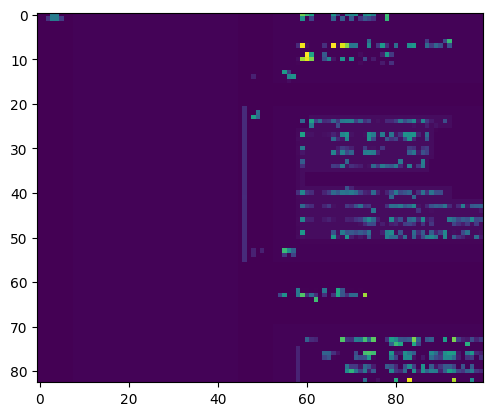

In [8]:
env = DinoGame()

obs = env.get_observation()
plt.imshow(obs[0])